# City Facilities Data Cleaning and Analysis

For this section, we'll be analyzing city facility data at large in SF using the `data/raw/City_Facilities_20251109.geojson` file. First, I'll begin by importing the necessary dependencies and loading the city facility data as well as the census tract data for mainland San Franciso.

In [21]:
# import necessary dependencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from census import Census
from us import states
import os
from pathlib import Path
from IPython.display import display
import seaborn as sns
import re
import zipfile
from shapely.geometry import Point
import folium

In [22]:
# use robust path handling to locate the data file
def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'requirements.txt').exists() or (p / '.git').exists():
            return p
    return start

repo_root = find_repo_root()
data_file = repo_root / 'data' / 'raw' / 'City_Facilities_20251109.geojson'

if not data_file.exists():
    raise FileNotFoundError(f"Data file not found at {data_file}. Check the file name and data/raw folder.")

# load the data from the data/raw folder
city_facilities_df = gpd.read_file(data_file, engine="pyogrio") # was having issue with fiona engine (so switching to pyogrio)

In [23]:
# load and extract SF census tracts shapefile
zip_path = repo_root / "data" / "raw" / "tl_2023_06_tract.zip"
out_dir = repo_root / "data" / "raw" / "tracts"

if not out_dir.exists():
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)

#  find shapefile inside extracted folder
tract_path = next(out_dir.glob("*.shp"), None)
if tract_path is None:
    raise FileNotFoundError("No .shp file found after extraction. Check the zip contents.")

# load shapefile using pyogrio for speed 
tracts = gpd.read_file(tract_path, engine="pyogrio")

# filter to SF County only (FIPS 075) 
sf_tracts = tracts[tracts["COUNTYFP"] == "075"].copy()

# filter to mainland SF (remove the Farallon Islands)
sf_tracts = sf_tracts.cx[-122.55:-122.35, 37.70:37.84]

# testing the SF boundary plot
# sf_tracts.boundary.plot();

#### Initial Look at the Raw Data via Visualizations

I'm interested in seeing how the different cateogories of amenities as described by our research report pdf is spread across San Francisco (like tracts in SF). In the `city_facilities_df`, there is a `department_name` column that gives some insight into this distribution, which works out as a great starting point.

In [24]:
# explore department_name values
city_facilities_df["department_name"].value_counts().head(10)

department_name
Recreation And Parks               570
Port                               213
School District (Sfusd)            156
Municipal Transportation Agency    127
Non-City                           126
Airport (Sfo)                      116
Public Utilities Commission        100
Fire Department                     57
Gsa - Real Estate Division          57
Public Health                       42
Name: count, dtype: int64

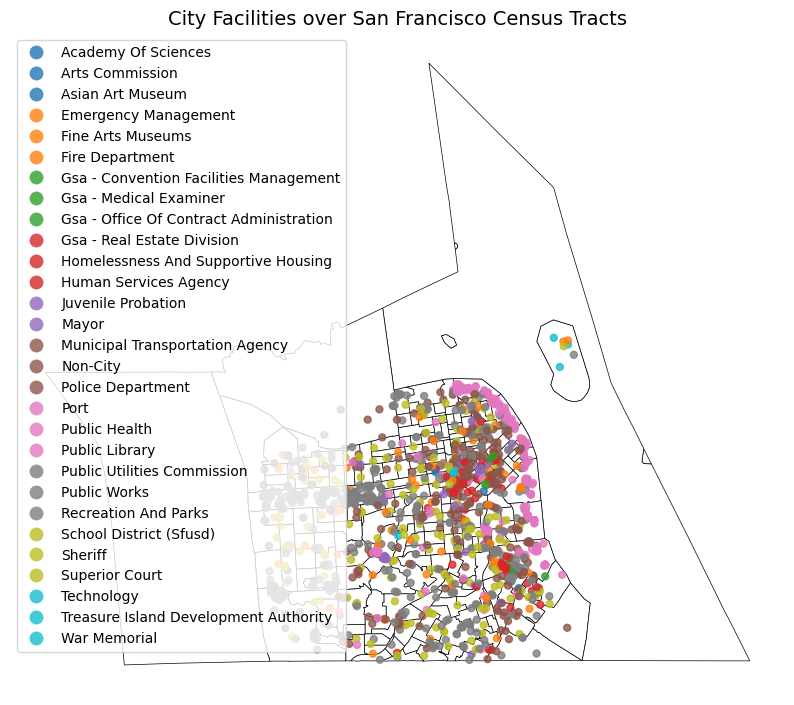

In [25]:
# make sure both are using the same coordinate reference system
city_facilities = city_facilities_df.to_crs(sf_tracts.crs)

# spatial join to find city facilities within SF census tracts 
city_facilities_sf = gpd.sjoin(city_facilities, sf_tracts, how="inner", predicate="within")

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sf_tracts.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
city_facilities_sf.plot(
    ax=ax,
    column="department_name",   # color by department
    categorical=True,
    legend=True,
    markersize=25,
    alpha=0.8,
)

# pptional styling
ax.set_title("City Facilities over San Francisco Census Tracts", fontsize=14)
ax.set_axis_off()
plt.show()

There are many categories under `department_name` which may not all be the most informative to our project, so I'll focus on highlighting the 5 main amenity categories, we want to focus on. Additionally, there are things I can do to improve the visual quality of the visualization by denoting what is land vs. water, using an interactive map via explore, and effective color schemes.

Here are some additions and changes I'll do to the data before the next visualization:

In [26]:
# create mapping from department_name to amenity category
amenity_map = {
    # recreational
    "Recreation And Parks": "Recreational",
    "Fine Arts Museums": "Recreational",
    "Arts Commission": "Recreational",
    "Asian Art Museum": "Recreational",
    "Academy Of Sciences": "Recreational",
    "War Memorial": "Recreational",

    # public services
    "School District (Sfusd)": "Public Services",
    "Municipal Transportation Agency": "Public Services",
    "Police Department": "Public Services",
    "Fire Department": "Public Services",
    "Public Health": "Public Services",
    "Public Library": "Public Services",
    "Sheriff": "Public Services",
    "Superior Court": "Public Services",
    "Human Services Agency": "Public Services",
    "Homelessness And Supportive Housing": "Public Services",
    "Juvenile Probation": "Public Services",

    # infrastructure
    "Public Utilities Commission": "Infrastructure",
    "Public Works": "Infrastructure",
    "Technology": "Infrastructure",
    "Port": "Infrastructure",
    "Gsa - Real Estate Division": "Infrastructure",
    "Gsa - Convention Facilities Management": "Infrastructure",

    # commercial (if relevant departments exist)
    "Treasure Island Development Authority": "Commercial",
    "Mayor": "Commercial",

    # Everything else
    "Non-City": "Other",
}

# create a new column for the amenity category
city_facilities_sf["amenity_category"] = city_facilities_sf["department_name"].map(amenity_map).fillna("Other")

# create a new column in sf_tracts for district mapping (dummy variable for now)
sf_tracts["district"] = (
    sf_tracts["GEOID"].astype(str).str[:2]  # crude example — replace later with real SF district mapping
)

# identify and label non-SF/water tracts
sf_tracts["is_water"] = sf_tracts["ALAND"].astype(float) == 0.0  # if ALAND == 0 → likely water
sf_tracts.loc[sf_tracts["is_water"], "district"] = "Water / Non-SF"

Plot as a non-interactive plot to get an idea of how each type of amenity is spread across San Francisco.

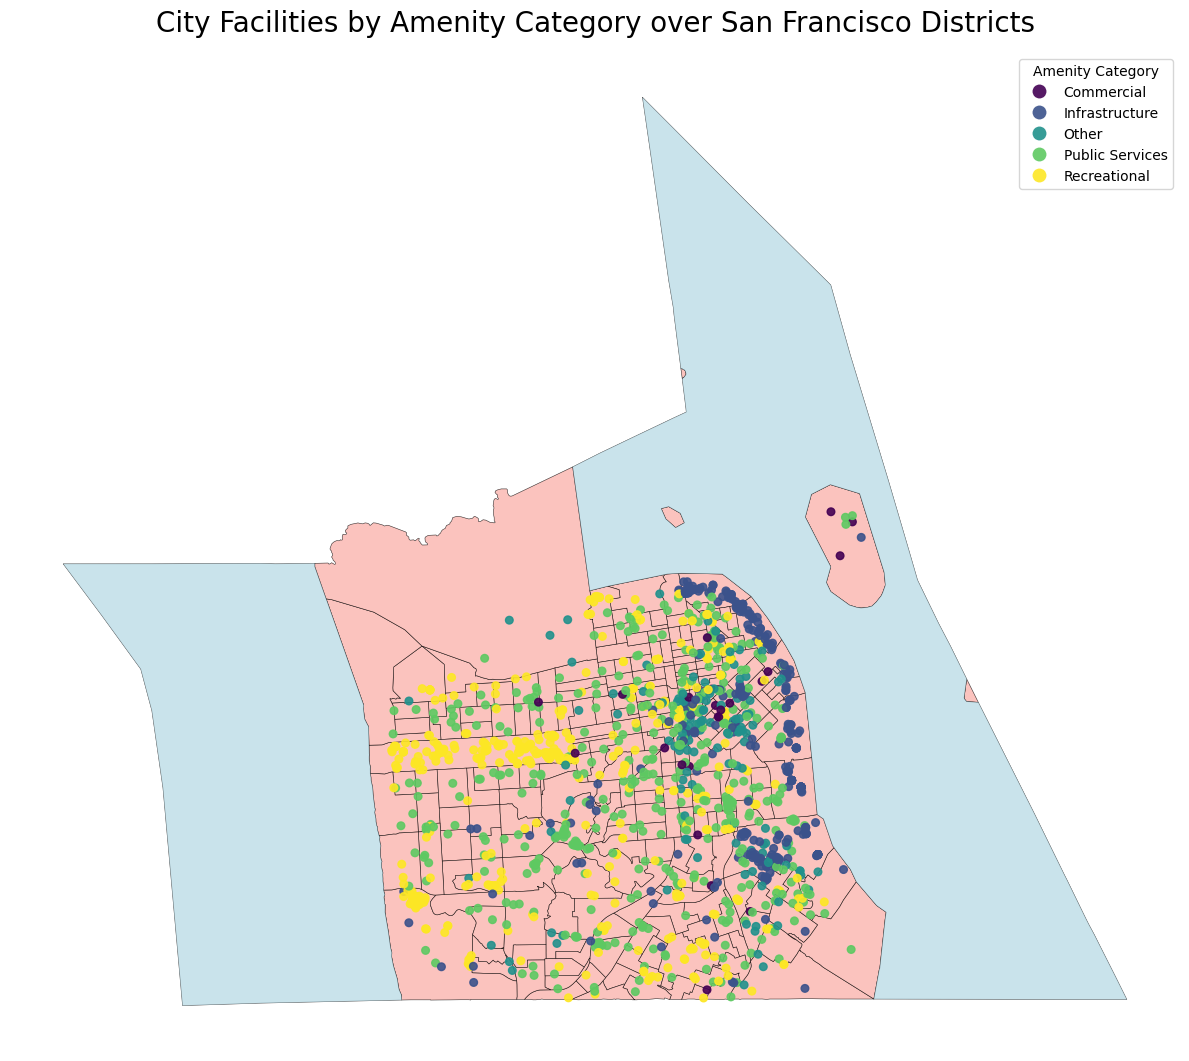

In [27]:
# plot with shaded polygons by district
fig, ax = plt.subplots(figsize=(12, 12))

# plot shaded tracts by district (light colormap)
sf_tracts.plot(
    ax=ax,
    column="district",
    cmap="Pastel1",
    edgecolor="black",
    linewidth=0.4,
    legend=True,
    alpha=0.8,
)

# highlight water/non-SF tracts separately in gray
sf_tracts[sf_tracts["district"] == "Water / Non-SF"].plot(
    ax=ax, color="lightblue", edgecolor="none", alpha=0.6
)

# plot city facilities on top
city_facilities_sf.plot(
    ax=ax,
    column="amenity_category",
    categorical=True,
    cmap="viridis", #tab10
    legend=True,
    markersize=30,
    alpha=0.9,
)

# style the plot
ax.set_title(
    "City Facilities by Amenity Category over San Francisco Districts",
    fontsize=20,
    pad=15,
)

# move the legend to the side
leg = ax.get_legend()
if leg:
    #leg.set_bbox_to_anchor((1.3, 0.5))  # play around for better aesthetics
    leg.set_title("Amenity Category")

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [28]:
# drop data/time related columns to use .explore/folium for interactive mapping later
city_facilities_sf_nodatetime = city_facilities_sf.drop(columns=['data_last_updated', 'data_as_of', 'data_loaded_at', ':created_at', ':updated_at'])

Create interactive html map and save it in the visualizations folder:

In [29]:
# base map showing shaded polygons by district
m = sf_tracts.explore(
    column="district",
    cmap="Pastel1",
    legend=True,
    style_kwds={"fillOpacity": 0.6, "weight": 0.4, "color": "black"},
    name="SF Districts",
)

# add water/non-SF tracts in light blue
sf_tracts[sf_tracts["district"] == "Water / Non-SF"].explore(
    m=m,
    color="lightblue",
    style_kwds={"fillOpacity": 0.6, "weight": 0},
    name="Water / Non-SF",
)

# add city facilities on top, colored by amenity category
city_facilities_sf_nodatetime.explore(
    m=m,
    column="amenity_category",
    cmap="viridis",
    legend=True,
    marker_kwds={"radius": 6, "fill": True, "fillOpacity": 0.9},
    name="City Facilities",
)

# add layer control
folium.LayerControl().add_to(m)

# m --> can't display directly in notebook (because Jupyter on VS code has issue with Trust Notebook), so save to HTML

# save to the visualizations folder instead
m.save(str(repo_root / 'visualizations' / 'city_facilities_map.html'))


#### Clean Data, focusing on `gross_sq_ft`

In [30]:
# check the dataframe structure
city_facilities_sf_nodatetime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1444 entries, 2 to 1732
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   :id                          1444 non-null   object  
 1   :version                     1444 non-null   object  
 2   facility_id                  1444 non-null   object  
 3   common_name                  1444 non-null   object  
 4   address                      1444 non-null   object  
 5   city                         1444 non-null   object  
 6   zip_code                     1444 non-null   object  
 7   block_lot                    1339 non-null   object  
 8   owned_leased                 1444 non-null   object  
 9   dept_id                      1444 non-null   object  
 10  department_name              1444 non-null   object  
 11  gross_sq_ft                  834 non-null    object  
 12  longitude                    1444 non-null   object  
 13  

In [31]:
# convert gross_sq_ft to numeric, coerce errors to NaN, being mindfull of commas
city_facilities_sf_nodatetime['gross_sq_ft'] = pd.to_numeric(
    city_facilities_sf_nodatetime['gross_sq_ft'].str.replace(',', '', regex=False),
    errors='coerce'
)

# describe numeric columns to check for anomalies
city_facilities_sf_nodatetime.describe(include=[np.number])

,gross_sq_ft,index_right,ALAND,AWATER
count,8.340000e+02,1444.000000,1.444000e+03,1.444000e+03
mean,4.169762e+04,5592.270776,1.474490e+06,3.841810e+05
std,1.159119e+05,2041.759451,1.563229e+06,1.492194e+06
min,0.000000e+00,341.000000,2.629500e+04,0.000000e+00
25%,1.836000e+03,3717.000000,3.362290e+05,0.000000e+00
50%,8.441500e+03,6342.000000,6.760890e+05,4.369000e+03
75%,3.362925e+04,6720.000000,2.096514e+06,4.094660e+05
max,2.120275e+06,8933.000000,6.126570e+06,2.032812e+07


In [ ]:
# join the updated Parks and Recreation gross_sq_ft and data changes from "data/raw/parks_and_rec_joined.geojson"
parks_rec_update_path = repo_root / "data" / "processed" / "parks_and_rec_joined.geojson"
parks_rec_update = gpd.read_file(parks_rec_update_path, engine="pyogrio")   

# Select only Recreation And Parks rows in city_facilities
mask = city_facilities_sf_nodatetime['department_name'] == 'Recreation And Parks'
parks_facilities = city_facilities_sf_nodatetime[mask].copy()

# Merge with the updated parks data on 'address' and 'common_name'
updated_merge = parks_facilities.merge(
    parks_rec_update[['address', 'common_name', 'gross_sq_ft']],
    on=['address', 'common_name'],
    how='left',
    suffixes=('', '_new')
)

# Update gross_sq_ft: use the new value if it exists, otherwise keep original
updated_merge['gross_sq_ft'] = updated_merge['gross_sq_ft_new'].combine_first(updated_merge['gross_sq_ft'])


# Drop the temporary column
updated_merge = updated_merge.drop(columns=['gross_sq_ft_new'])

# Put updated rows back into the original GeoDataFrame
city_facilities_sf_nodatetime.loc[mask, 'gross_sq_ft'] = updated_merge['gross_sq_ft'].values

city_facilities_sf_nodatetime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1444 entries, 2 to 1732
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   :id                          1444 non-null   object  
 1   :version                     1444 non-null   object  
 2   facility_id                  1444 non-null   object  
 3   common_name                  1444 non-null   object  
 4   address                      1444 non-null   object  
 5   city                         1444 non-null   object  
 6   zip_code                     1444 non-null   object  
 7   block_lot                    1339 non-null   object  
 8   owned_leased                 1444 non-null   object  
 9   dept_id                      1444 non-null   object  
 10  department_name              1444 non-null   object  
 11  gross_sq_ft                  1003 non-null   float64 
 12  longitude                    1444 non-null   object  
 13  

Explore the rows with missing `gross_sq_ft` values:

city_facilities_sf_nodatetime